# Desafio Técnico

Importação de bibliotecas:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from sklearn import preprocessing
from math import log
import numpy as np
from sklearn.model_selection import StratifiedKFold
import optuna
from random import randint
from time import time
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

In [2]:
sns.set(color_codes=True)

### Parte 1: Classificação

Implementação Algoritmo K-nn:

In [3]:
class k_nearest_neighbor:
    def __init__(self, k=1, tipo="classifier"):
        self.k = k
        self.tipo = tipo
        self.data = None
        self.att = None
        self.target = None
        self.y = None
        
        
    def fit(self, data, target):
        self.data = data.copy()
        #print(data.shape)
        self.target = target
        self.att = [col for col in data if col != target]
        self.y = list(data[target].unique()) if self.tipo == 'classifier' else list(data[target].unique())
    
    def get_k_neighbors(self, x1):
        k = self.k
        att = self.att
        target = self.target
        #classes = list(data[target].unique())
        #x1 = df.iloc[7][att]
        x1 = x1[att]
        d = self.data[att]-x1
        d[target] = self.data[target]
        d[att] = d[att]**2
        d['distance'] = d[att].sum(axis=1)**(1/2)
        d = d.sort_values(by=['distance'])
        nn = d.iloc[:k]
        #print('KNN')
        #print(nn)
        return nn
    
    def classification(self, x1):
        classes = self.y
        nn = self.get_k_neighbors(x1)
        if self.tipo == "classifier":
            nn_classes = list(nn[self.target])
            maximo = 0
            tag = None
            for t in classes:
                contador = nn_classes.count(t)
                if contador > maximo:
                    maximo = contador
                    tag = t
        return tag
    
    def regression(self, x1):
        fx = self.y
        nn = self.get_k_neighbors(x1)
        #print(nn)
        if self.tipo == "regressor":
            nn_fx = list(nn[self.target])
            r = sum(nn_fx)/self.k
    
        return r
    
    def predict(self, X):
        if self.tipo == 'classifier':
                if type(X) == type(pd.DataFrame()):
                    predictions = []
                    for i in range(X.shape[0]):
                        predictions.append(self.classification(X.iloc[i]))
                elif type(X) == type(pd.Series()):
                    predictions = (self.classification(X))
        
        elif self.tipo == 'regressor':
                if type(X) == type(pd.DataFrame()):
                    predictions = []
                    for i in range(X.shape[0]):
                        predictions.append(self.regression(X.iloc[i]))
                elif type(X) == type(pd.Series()):
                    predictions = (self.regresion(X))
        
        return predictions
    
    
    def acc_score(self, d):
        r = (d['tp'] + d['tn'])/(d['tp'] + d['tn'] + d['fn'] + d['fp'])
        return r
    
    def prec_score (self, d):
        if d['tp'] + d['fp'] == 0:
            r = 0
        else:
            r = d['tp']/(d['tp'] + d['fp'])
        
        return r
    
    def recc_score (self, d):
        if d['tp'] + d['fn'] == 0:
            r = 0
        else:
            r = d['tp']/(d['tp'] + d['fn'])
        
        return r
    
    def f_score(self, d, beta=1):
        precision = self.prec_score(d)
        recall = self.recc_score(d)
        if (((beta**2)*precision) + recall) == 0:
            r = 0
        else:
            r = (1+beta**2) * ((precision*recall)/(((beta**2)*precision) + recall))
    
        return r
    
    def rmse_calc(self, y_true, y_pred):
        sqr_sum = sum([(i[0]-i[1])**2 for i in zip(y_true, y_pred)])/len(y_true)
        return sqr_sum**(1/2)
    
    def r2_calc(self, y_true, y_pred):
        y_true_mean = sum(y_true)/len(y_true)
        ss_total = sum([(i-y_true_mean)**2 for i in y_true])
        ss_resid = sum([(i[0]-i[1])**2 for i in zip(y_true, y_pred)])
        r2 = 1 - (ss_resid/ss_total) if ss_total != 0 else 1
        
        return r2
    
    def pearson_cor_calc(self, y_true, y_pred):
        y_true_mean = sum(y_true)/len(y_true)
        y_pred_mean = sum(y_pred)/len(y_pred)
        y_true_res = [(i-y_true_mean) for i in y_true]
        y_pred_res = [(i-y_pred_mean) for i in y_pred]
        cov = sum([i[0]*i[1] for i in zip(y_true_res, y_pred_res)])
        den = (sum([(i-y_true_mean)**2 for i in y_true])**(1/2)) * (sum([(i-y_pred_mean)**2 for i in y_pred])**(1/2))
        p = cov/den
        
        return p
        
        
    def evaluate(self, y_true, y_pred, target_class=1):
        #print(y_true)
        #print(y_pred)
        y_true = list(y_true)
        y_pred = list(y_pred)
        model = f"{self.k}-nn ({self.tipo})"
        metrics = {model: {}}
        
        if self.tipo == "classifier":
            d = {}
            d['tp'] = sum([i[0] == i[1] for i in zip(y_true, y_pred) if i[0]==target_class])
            d['tn'] = sum([i[0] == i[1] for i in zip(y_true, y_pred) if i[0]!=target_class])
            d['fp'] = y_pred.count(target_class) - d['tp']
            d['fn'] = len(y_pred) - (d['tp'] + d['tn'] + d['fp'])

            metrics[model]['Accuracy'] = self.acc_score(d)
            metrics[model]['Recall'] = self.recc_score(d)
            metrics[model]['Precision'] = self.prec_score(d)
            metrics[model]['F1 Score'] = self.f_score(d)
            metrics[model]['F2 Score'] = self.f_score(d, beta=2)
            
        elif self.tipo == "regressor":
            metrics[model]['RMSE'] = self.rmse_calc(y_true, y_pred)
            metrics[model]['R2'] = self.r2_calc(y_true, y_pred)
            metrics[model]['Person Corr'] = self.pearson_cor_calc(y_true, y_pred)
            
        return pd.DataFrame().from_dict(metrics, orient='index')

In [4]:
df = pd.read_csv("data/classification_train.csv")
df.head()

,x1,x2,target
0,1.934224,-0.111822,1
1,1.767383,-0.976402,1
2,0.937101,-0.085633,1
3,1.340732,0.166960,1
4,-0.199901,-0.155204,1


In [5]:
df_test = pd.read_csv("data/classification_test.csv")
df_test.head()

,x1,x2,target
0,1.114204,-0.434321,1
1,-1.238490,0.521390,0
2,-0.091781,-0.169471,1
3,0.298820,0.076368,0
4,-0.265779,0.479812,1


In [6]:
results = pd.DataFrame()
for k in range(1, 30):
    knn = k_nearest_neighbor(k=k)
    knn.fit(df, 'target')
    y_pred = knn.predict(df_test)
    r = knn.evaluate(df_test['target'], y_pred)
    results = results.append(r)

In [7]:
def highlight_max(x):
    return ['font-weight: bold' if v == max(list(x)) else ''
                for v in x]

In [8]:
results.style.apply(highlight_max)

,Accuracy,Recall,Precision,F1 Score,F2 Score
1-nn (classifier),0.824242,0.819876,0.819876,0.819876,0.819876
2-nn (classifier),0.809091,0.906832,0.752577,0.822535,0.871122
3-nn (classifier),0.869697,0.881988,0.855422,0.868502,0.876543
4-nn (classifier),0.851515,0.900621,0.814607,0.855457,0.881995
5-nn (classifier),0.872727,0.875776,0.865031,0.87037,0.873606
6-nn (classifier),0.866667,0.89441,0.842105,0.86747,0.883436
7-nn (classifier),0.869697,0.881988,0.855422,0.868502,0.876543
8-nn (classifier),0.866667,0.900621,0.83815,0.868263,0.887393
9-nn (classifier),0.872727,0.89441,0.852071,0.872727,0.885609
10-nn (classifier),0.857576,0.89441,0.827586,0.859701,0.880196


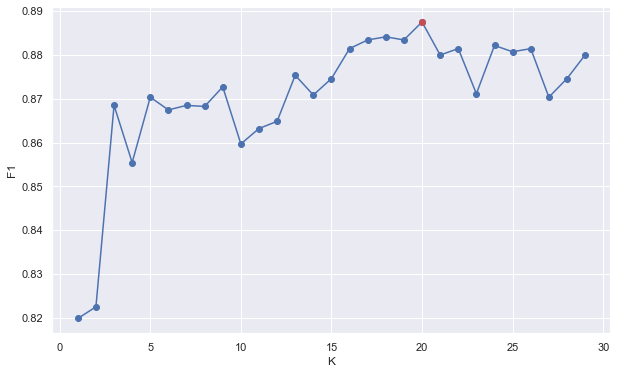

In [9]:
y = list(results['F1 Score'])
x = list(range(1, len(y)+1))
i = y.index(max(y))
p = (x[i], y[i])
plt.figure(figsize=(10,6))
plt.xlabel('K')
plt.ylabel('F1')
plt.plot(x,y,marker='o');
plt.plot(p[0],p[1],marker='o', color='r');

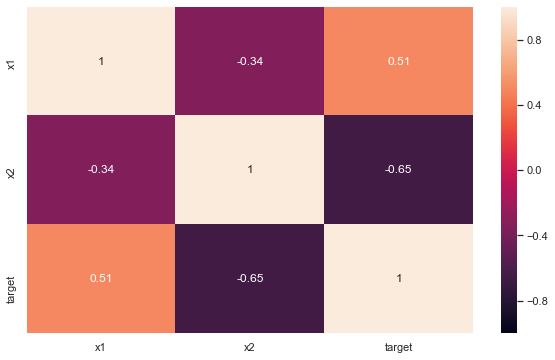

In [10]:
plt.figure(figsize=(10, 6))
corrMatrix = df.corr()
ax = sns.heatmap(corrMatrix, annot=True, vmin=-1,vmax=1)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

### Parte 2: Regressão

In [11]:
df2 = pd.read_csv("data/regression_train.csv")
df2.head()

,target,X1,X2,X3,X4,X5,X6,X7
0,NaN,-0.546168,NaN,47.063305,1.611370,-65.882137,0,-16.672865
1,47.735389,3.074317,-2.836000,49.396649,0.261998,-66.570716,0,-6.664599
2,NaN,-1.485531,-13.102537,42.367991,3.991558,-67.108014,8,-30.790962
3,908.202209,6.907396,-0.308967,57.228787,0.256771,-66.181266,5,-0.726072
4,1640.461863,1.916788,3.460290,51.703375,2.463790,-65.143663,5,8.131680


In [12]:
counts = {col: [df2[col].isnull().sum()] for col in df2}
print(counts)
missing_values = pd.DataFrame.from_dict(counts, orient='index', columns=['Missing Values'])
missing_values

{'target': [327], 'X1': [0], 'X2': [11], 'X3': [0], 'X4': [0], 'X5': [0], 'X6': [0], 'X7': [0]}


,Missing Values
target,327
X1,0
X2,11
X3,0
X4,0
X5,0
X6,0
X7,0


In [13]:
df2.shape

(1042, 8)

In [14]:
df2 = df2.dropna(subset=['target'])
df2.shape

(715, 8)

In [15]:
df_test2 = pd.read_csv("data/regression_test.csv")
df_test2.head()

,target,X1,X2,X3,X4,X5,X6,X7
0,3.436244,0.210854,-2.451307,51.239996,4.641751,-67.874319,5,-5.760571
1,1525.839412,2.157483,4.337776,43.828794,8.070219,-68.405526,8,10.193773
2,455.600191,5.166359,-0.452615,43.931305,1.349625,-66.240021,0,-1.063645
3,0.619759,3.276641,-3.607201,50.631046,2.473542,-69.971690,8,-8.476921
4,10.996472,-1.867485,-2.408863,58.660224,2.826219,-53.647149,5,-5.660827


In [16]:
counts = {col: [df_test2[col].isnull().sum()] for col in df_test2}
print(counts)
missing_values = pd.DataFrame.from_dict(counts, orient='index', columns=['Missing Values'])
missing_values

{'target': [81], 'X1': [0], 'X2': [0], 'X3': [0], 'X4': [0], 'X5': [0], 'X6': [0], 'X7': [0]}


,Missing Values
target,81
X1,0
X2,0
X3,0
X4,0
X5,0
X6,0
X7,0


In [17]:
df_test2 = df_test2.dropna(subset=['target'])
df_test2.shape

(180, 8)

In [18]:
results2 = pd.DataFrame()
for k in range(1, 30):
    knn = k_nearest_neighbor(k=k, tipo='regressor')
    knn.fit(df2, 'target')
    y_pred = knn.predict(df_test2)
    r = knn.evaluate(df_test2['target'], y_pred)
    results2 = results2.append(r)

In [19]:
results2

,RMSE,R2,Person Corr
1-nn (regressor),393.032088,0.903198,0.951716
2-nn (regressor),361.674250,0.918028,0.958800
3-nn (regressor),343.129431,0.926219,0.963600
4-nn (regressor),342.848850,0.926340,0.964271
5-nn (regressor),334.688122,0.929805,0.966358
6-nn (regressor),300.122087,0.943555,0.972599
7-nn (regressor),291.987262,0.946574,0.974529
8-nn (regressor),289.773947,0.947381,0.975096
9-nn (regressor),279.749221,0.950958,0.976646
10-nn (regressor),286.322003,0.948627,0.975834


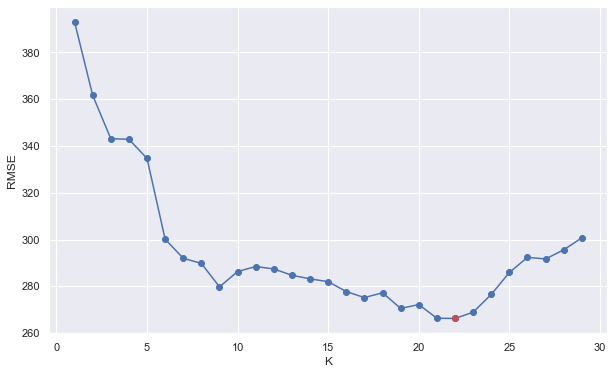

In [20]:
y = list(results2['RMSE'])
x = list(range(1, len(y)+1))
i = y.index(min(y))
p = (x[i], y[i])
plt.figure(figsize=(10,6))
plt.xlabel('K')
plt.ylabel('RMSE')
plt.plot(x,y,marker='o');
plt.plot(p[0],p[1],marker='o', color='r');

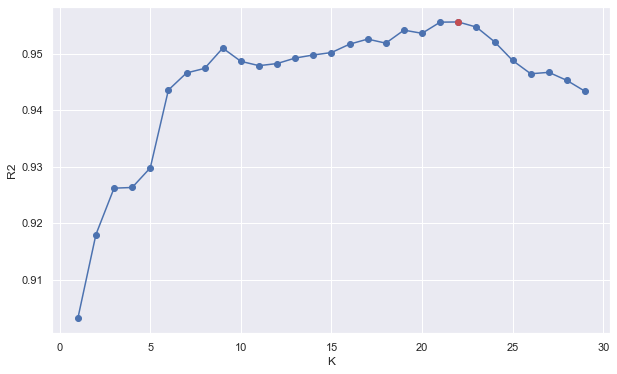

In [21]:
y = list(results2['R2'])
x = list(range(1, len(y)+1))
i = y.index(max(y))
p = (x[i], y[i])
plt.figure(figsize=(10,6))
plt.xlabel('K')
plt.ylabel('R2')
plt.plot(x,y,marker='o');
plt.plot(p[0],p[1],marker='o', color='r');

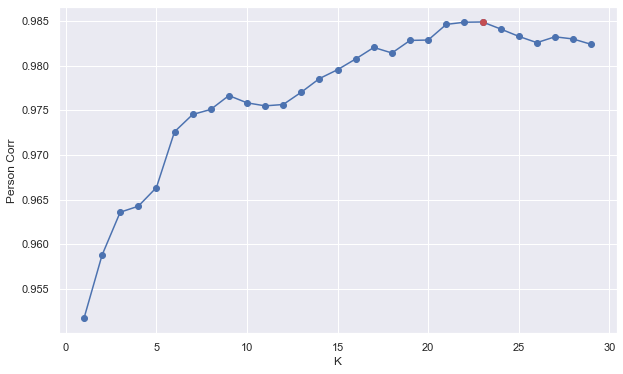

In [22]:
y = list(results2['Person Corr'])
x = list(range(1, len(y)+1))
i = y.index(max(y))
p = (x[i], y[i])
plt.figure(figsize=(10,6))
plt.xlabel('K')
plt.ylabel('Person Corr')
plt.plot(x,y,marker='o');
plt.plot(p[0],p[1],marker='o', color='r');

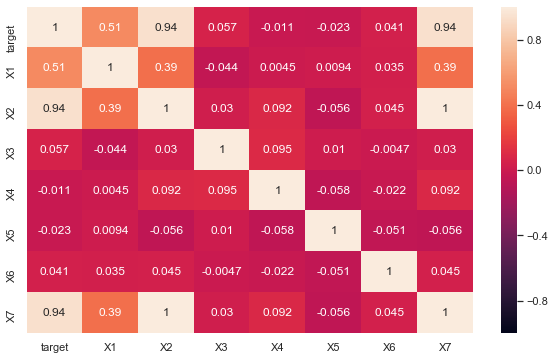

In [23]:
plt.figure(figsize=(10, 6))
corrMatrix = df2.corr()
ax = sns.heatmap(corrMatrix, annot=True, vmin=-1,vmax=1)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

In [24]:
class k_means:
    def __init__(self, k=1, tol=0.001, max_iter=100):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter
        self.data = None
        self.centroids = None
        self.att = None
        self.elapsed_time = None
    
    def fit(self, data, centroids=None):
        self.data = data.copy()
        self.centroids = centroids
        self.att = [col for col in data]
        att = self.att
        
        f = lambda x : x.index(min(x))
        
        t0 = time()
        
        if not self.centroids:
            self.centroids = []
            for i in range(self.k):
                lim = self.data.shape[0] - 1
                aux = randint(0, lim)
                self.centroids.append(self.data.iloc[aux])
        
        self.distances = [[]]*self.k
        
        cont = 0
        stop = False
        
        while (cont < self.max_iter) and (not stop):
            for i in range(len(self.centroids)):
                c = self.centroids[i]
                d = self.data[att] - c
                d = d**2
                self.distances[i] = d.sum(axis=1)**(1/2)
                #self.data[f'distance_{i}'] = d.sum(axis=1)**(1/2)

            classes = []
            for j in range(len(self.distances[0])):
                aux = []
                for i in range(self.k):
                    aux.append(self.distances[i][j])
                classes.append(f(aux))

            #print(len(classes))
            self.data['cluster'] = classes

            old_centroids = []
            for i in range(len(self.centroids)):
                aux_l = [j == i for j in classes]
                aux = self.data[aux_l][att]
                #aux = self.data[self.data['cluster'] == i][att]
                aux = aux.sum()/aux.shape[0]
                old_centroids.append(self.centroids[i])
                self.centroids[i] = aux

            for i in range(len(old_centroids)):
                d = old_centroids[i]-self.centroids[i]
                d = d**2
                d = d.sum()**(1/2)
                if d > self.tol:
                    stop = False
                    break
                else:
                    stop = True
                    #print(f"Convergiu {i}")
            cont += 1
        print(f"Iterações -> {cont}")
        tf = time()-t0
        self.elapsed_time = tf
        
    
    def evaluate(self):
        model = f"k={self.k}"
        metrics = {model: {}}
        
        wcss = 0
        inertia = 0
        
        data_aux = self.data[self.att + ["cluster"]].copy()
        for i in range(self.k):
            data_aux[f'distance_{i}'] = self.distances[i]
        
        for i in range(self.k):
            #print(i)
            c = self.centroids[i]
            #s = data_aux[data_aux['cluster'] == i][self.att]
            s = data_aux[data_aux['cluster'] == i]
            s = s[f'distance_{i}']
            intra_inert = (s**2).sum()
            inertia += intra_inert
            #l = s.shape[0]
            #s = (s-c)**2
            #s = s.sum(axis=1)**(1/2)
            #s = s**2
            #v = s.sum()
            #v = v/(2*l)
            #wcss += v
        
        metrics[model]['Time'] = self.elapsed_time
        #metrics[model]['WCSS'] = wcss
        metrics[model]['Inertia'] = inertia
        metrics[model]['Calinski-Harabasz'] = calinski_harabasz_score(self.data[self.att], self.data['cluster'])
        metrics[model]['Davies-Bouldin'] = davies_bouldin_score(self.data[self.att], self.data['cluster'])
        metrics[model]['Silhouette'] = silhouette_score(self.data[self.att], self.data['cluster'])
        
        return pd.DataFrame().from_dict(metrics, orient='index')

In [25]:
clust = pd.read_csv("data/clusterization.csv")
clust.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,1.788532,1.514571,1.965787,1.788532,1.839011,0.027213,4.287439,1.103957,0.272501,0.390037
1,1.137568,-0.537787,0.405860,1.137568,1.177157,0.881743,2.289545,-0.427406,-0.227506,0.452705
2,0.861253,2.133148,-1.285062,0.861253,1.654487,0.104453,-0.858607,0.455393,-1.066773,-0.382173
3,1.630619,-0.000408,0.688288,1.630619,2.688988,2.321262,1.977060,0.234256,-1.424967,-0.864576
4,2.339800,-3.593987,-4.507650,2.339800,-3.642843,0.772287,2.938295,1.424821,-0.171201,4.652432


In [26]:
counts = {col: [clust[col].isnull().sum()] for col in clust}
print(counts)
missing_values = pd.DataFrame.from_dict(counts, orient='index', columns=['Missing Values'])
missing_values

{'x0': [0], 'x1': [0], 'x2': [0], 'x3': [0], 'x4': [0], 'x5': [0], 'x6': [0], 'x7': [0], 'x8': [0], 'x9': [0]}


,Missing Values
x0,0
x1,0
x2,0
x3,0
x4,0
x5,0
x6,0
x7,0
x8,0
x9,0


In [27]:
clust = pd.read_csv("data/clusterization.csv")
normalized_clust = (clust-clust.min())/(clust.max()-clust.min())
normalized_clust.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,0.634010,0.545410,0.487850,0.634010,0.478955,0.447594,0.771623,0.540575,0.429154,0.513463
1,0.582226,0.440984,0.412844,0.582226,0.435249,0.497873,0.613390,0.429208,0.388343,0.518341
2,0.560245,0.576885,0.331539,0.560245,0.466770,0.452139,0.364058,0.493408,0.319841,0.453353
3,0.621448,0.468326,0.426424,0.621448,0.535084,0.582572,0.588642,0.477326,0.290605,0.415802
4,0.677864,0.285480,0.176587,0.677864,0.116956,0.491433,0.664771,0.563909,0.392939,0.845254


In [28]:
results_norm = pd.DataFrame()
for x in range(2, 20):
    print(x)
    c = k_means(k=x)
    c.fit(normalized_clust)
    results_norm = results_norm.append(c.evaluate())
results_norm

2
Iterações -> 14
3
Iterações -> 13
4
Iterações -> 32
5
Iterações -> 18
6
Iterações -> 62
7
Iterações -> 77
8
Iterações -> 76
9
Iterações -> 99
10
Iterações -> 100
11
Iterações -> 95
12
Iterações -> 56
13
Iterações -> 57
14
Iterações -> 94
15
Iterações -> 46
16
Iterações -> 49
17
Iterações -> 90
18
Iterações -> 89
19
Iterações -> 81


,Time,Inertia,Calinski-Harabasz,Davies-Bouldin,Silhouette
k=2,10.403406,1681.534378,3731.412735,1.892475,0.181604
k=3,11.248793,1464.079627,3256.357850,1.765837,0.163571
k=4,37.239921,1347.016614,2793.842339,1.774181,0.147006
k=5,24.484605,1277.480437,2413.326493,1.857830,0.128255
k=6,116.791713,1190.885792,2288.975358,1.778180,0.132074
k=7,156.665544,1142.552503,2093.745105,1.762552,0.127126
k=8,178.565553,1089.318209,1986.864117,1.689527,0.133549
k=9,249.312326,1055.351151,1854.659274,1.734506,0.126624
k=10,316.876921,1016.930924,1773.697701,1.711539,0.127028
k=11,300.949838,986.314212,1692.297050,1.646111,0.129745


In [29]:
y = list(results_norm['Inertia'])
x = list(range(2,len(y)+2))

In [30]:
def distance_line_point(p0, p1, x, y):
    x0 = p0[0]
    y0 = p0[1]
    x1 = p1[0]
    y1 = p1[1]
    
    '''if (x0, y0) == (x, y) or (x1, y1) == (x, y):
        return 0
    '''
    a = ((y1-y0)*x) - ((x1-x0)*y) + (x1*y0) - (x0*y1)
    b = ((y1-y0)**2 + (x1-x0)**2)**(1/2)
    a = a if a > 0 else -a
    
    return a/b

In [31]:
dists = [distance_line_point((x[0],y[0]), (x[-1], y[-1]), i[0], i[1]) for i in zip(x, y)]
print(dists)
best_k = dists.index(max(dists)) + 2
print(f"Melhor valor de k é {best_k}")

[7.932946867268431e-16, 3.299427948746475, 4.614041036117235, 4.989015342678368, 5.70124748482367, 5.657025865008787, 5.709700525421811, 5.38144848967311, 5.141238697219453, 4.746747966617084, 4.317840877333098, 3.7870982220447487, 3.317958910106907, 2.629167708603008, 2.0540654322215075, 1.4093918088432904, 0.6942909152910721, 7.932946867268431e-16]
Melhor valor de k é 8


In [32]:
dists[0] > 1

False

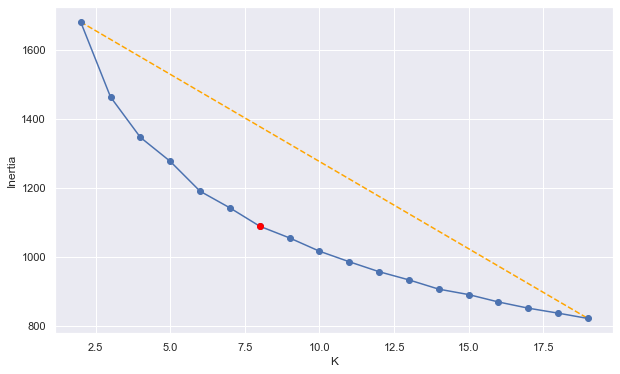

In [33]:
plt.figure(figsize=(10,6))
plt.xlabel('K')
plt.ylabel('Inertia')
plt.plot([x[0], x[-1]],[y[0], y[-1]], 'r--', color='orange')
plt.plot(x,y,marker='o');
plt.plot(x[best_k-2],y[best_k-2],marker='o', color='red');

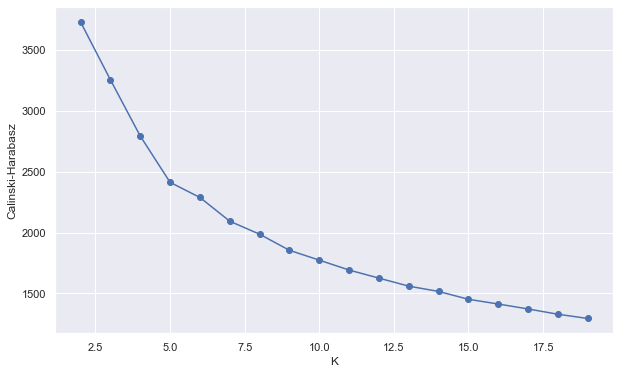

In [34]:
y = list(results_norm['Calinski-Harabasz'])
plt.figure(figsize=(10,6))
plt.xlabel('K')
plt.ylabel('Calinski-Harabasz')
#plt.plot([x[0], x[-1]],[y[0], y[-1]], 'r--', color='orange')
plt.plot(x,y,marker='o');

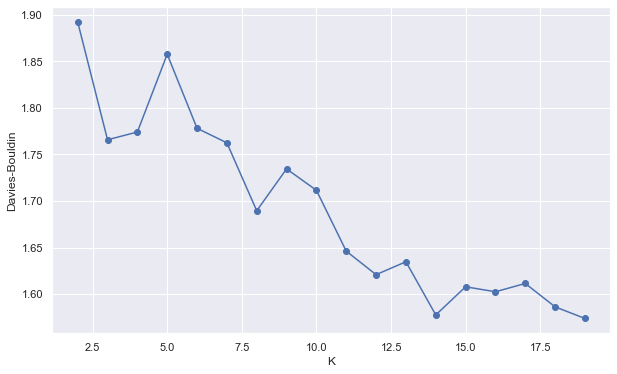

In [35]:
y = list(results_norm['Davies-Bouldin'])
plt.figure(figsize=(10,6))
plt.xlabel('K')
plt.ylabel('Davies-Bouldin')
plt.plot(x,y,marker='o');

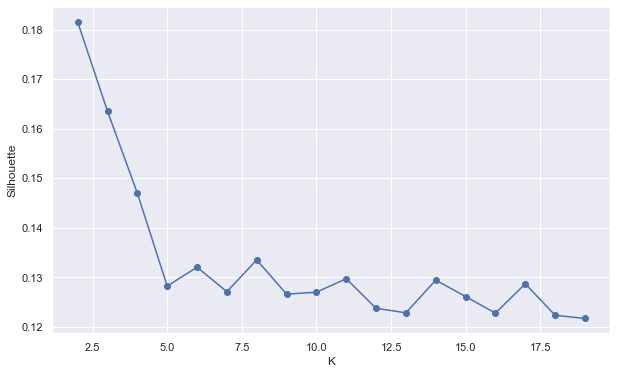

In [36]:
y = list(results_norm['Silhouette'])
plt.figure(figsize=(10,6))
plt.xlabel('K')
plt.ylabel('Silhouette')
plt.plot(x,y,marker='o');